In [ ]:
from datetime import datetime as dt
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.metrics import AUC
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import BinaryFocalCrossentropy
from keras.regularizers import l2
from keras.models import load_model

# Charger le modèle avec les meilleurs poids

In [62]:
def plot_history(history, metric='accuracy'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history[metric], 'b', label='Training accuracy')
    plt.plot(history.history[f'val_{metric}'],'r', label='Validation accuracy')
    plt.title('Training and validation auc')
    plt.legend()

# Preprocessing

In [ ]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [ ]:
train.shape

(165034, 11)

In [ ]:
X = train.drop(columns='Exited')
y = train.Exited

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
y_resampled.value_counts(True)

Exited
0    0.5
1    0.5
Name: proportion, dtype: float64

In [ ]:
prepro = Preprocessing()

In [ ]:
X_train_scld = prepro.fit_transform(X_resampled).astype(float)
X_test_scld = prepro.transform(X_test).astype(float)

In [ ]:
X_train_scld

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
id,,,,,,,,,,,,
94098,-1.041872,0.0,-0.147845,0.9,-1.008866,0.333333,1.0,1.0,0.760201,1.0,0.0,0.0
14283,1.104061,1.0,-0.035926,0.9,-1.008866,0.333333,0.0,0.0,0.495285,0.0,0.0,1.0
10835,-1.798530,0.0,-0.500538,0.4,-1.008866,0.333333,0.0,0.0,-0.302204,1.0,0.0,0.0
96632,0.955210,1.0,-1.753957,0.7,-1.008866,0.333333,0.0,0.0,0.818313,1.0,0.0,0.0
73938,0.868380,0.0,-0.147845,1.0,-1.008866,0.333333,0.0,1.0,-0.200273,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
70064,0.855976,1.0,0.284731,0.2,-1.008866,0.333333,1.0,0.0,-0.829276,1.0,0.0,0.0
12077,-0.285214,1.0,0.487032,0.4,1.018439,0.000000,1.0,0.0,-1.290879,1.0,0.0,0.0
93937,-0.136363,0.0,0.073397,0.9,0.952176,0.000000,1.0,0.0,-0.084712,1.0,0.0,0.0


# Model

In [ ]:
X_train_scld.shape

(52382, 12)

8

In [91]:
# params Model
firstunits = 128
dropout_rate = 0.3
regularizer = l2(1e-3)

# calcul units
max_power = int(np.log2(firstunits))
units = [2**i for i in range(max_power,max_power-4,-1)]

# Build Model
model = Sequential(name="BankChurn")

model.add(Dense(units=units[0], activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizer, name="Dense1"))
model.add(BatchNormalization(name="BatchNorm1"))
model.add(Dropout(dropout_rate, name="Dropout1"))

model.add(Dense(units=units[1], activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizer, name="Dense2"))
model.add(BatchNormalization(name="BatchNorm2"))
model.add(Dropout(dropout_rate, name="Dropout2"))

model.add(Dense(units=units[2], activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizer, name="Dense3")) 
model.add(BatchNormalization(name="BatchNorm3"))
model.add(Dropout(dropout_rate, name="Dropout3"))

model.add(Dense(units=units[3], activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizer, name="Dense4")) 
model.add(BatchNormalization(name="BatchNorm4"))


model.add(Dense(units=1, activation='sigmoid',kernel_initializer='glorot_uniform',  name="Output"))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=BinaryFocalCrossentropy(),
    metrics=['accuracy']
    )



early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_scld.values,
    y_resampled.values,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    shuffle=True,
    #callbacks=[early_stopping]
    )

Epoch 1/10
655/655 [==============================] - 40s 57ms/step - loss: 1.0337 - accuracy: 0.4513 - val_loss: 0.8015 - val_accuracy: 0.4182
Epoch 2/10
655/655 [==============================] - 35s 53ms/step - loss: 1.0075 - accuracy: 0.4586 - val_loss: 0.7803 - val_accuracy: 0.4308
Epoch 3/10
655/655 [==============================] - 35s 53ms/step - loss: 0.9864 - accuracy: 0.4636 - val_loss: 0.7720 - val_accuracy: 0.4218
Epoch 4/10
655/655 [==============================] - 36s 55ms/step - loss: 0.9666 - accuracy: 0.4720 - val_loss: 0.7439 - val_accuracy: 0.4536
Epoch 5/10
655/655 [==============================] - 37s 56ms/step - loss: 0.9435 - accuracy: 0.4756 - val_loss: 0.7308 - val_accuracy: 0.4600
Epoch 6/10
655/655 [==============================] - 35s 54ms/step - loss: 0.9193 - accuracy: 0.4819 - val_loss: 0.7125 - val_accuracy: 0.4799
Epoch 7/10
655/655 [==============================] - 36s 54ms/step - loss: 0.9020 - accuracy: 0.4928 - val_loss: 0.6959 - val_accuracy:

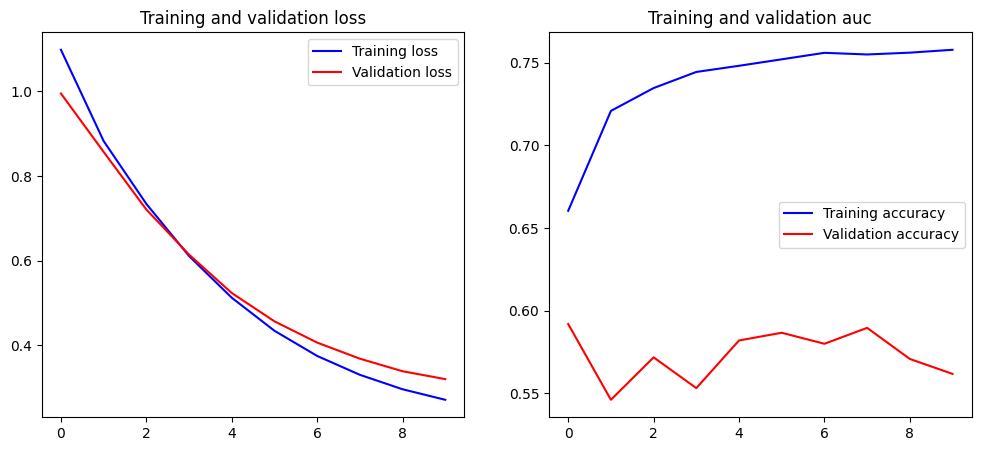

In [ ]:
plot_history(history, 'accuracy')

In [64]:
pred = model.predict(X_test_scld.values)

1290/1290 [==============================] - 4s 3ms/step


# Score

In [65]:
RocScore  = roc_auc_score(y_test, pred[:,0])
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.817364


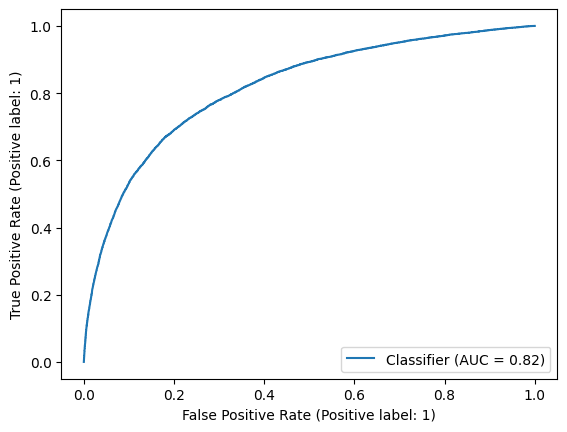

In [66]:
RocCurveDisplay.from_predictions(y_test,pred)

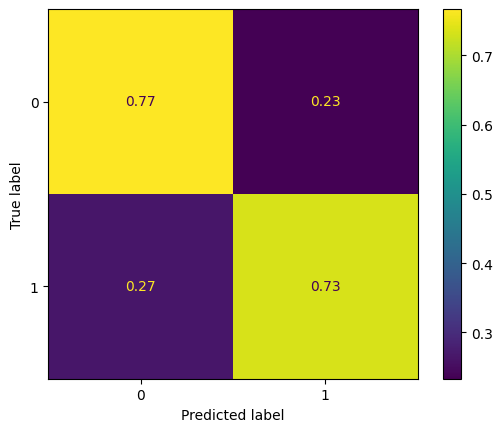

In [74]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred[:,0]>0.5, normalize='true')).plot()

# Submission

In [ ]:
X_val_scld = prepro.transform(test)

In [ ]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [ ]:
submission.loc[:,'Exited'] = nn.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
submission

,Exited
id,
165034,0.085936
165035,0.947197
165036,0.079534
165037,0.519489
165038,0.638603
...,...
275052,0.132850
275053,0.217605
275054,0.071276


In [ ]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [ ]:
#submission.to_csv(f"submission/{name}.csv")